# monthly USEC EOFs

In [43]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def detrend_linear2(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:,:]

def detrend_linear_tg(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:]
    
def detrend_deseason_tg(da): #order/fs/low pass filter unused so far
    [fosi_det, fosi_trend]=detrend_linear_tg(da, 'time')
    fosi_trend=fosi_trend * 1e9  * 60  * 60  * 24 * 365
    fosi_mean_sea=fosi_det.groupby("time.month").mean("time")
    fosi_desea=fosi_det.groupby("time.month")-fosi_mean_sea  
    return fosi_desea.drop_vars('month'), fosi_trend
    
def detrend_deseason(da): #order/fs/low pass filter unused so far
    [fosi_det, fosi_trend]=detrend_linear2(da, 'time')
    fosi_trend=fosi_trend * 1e9  * 60  * 60  * 24 * 365
    fosi_mean_sea=fosi_det.groupby("time.month").mean("time")
    fosi_desea=fosi_det.groupby("time.month")-fosi_mean_sea
    return fosi_desea.drop_vars('month'), fosi_trend

In [47]:
ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.001.pop.h.000101_006612.SSH.nc')
                   # , parallel=True)
ds=ds.chunk(40, 100, 100)
# ds=xr.open_mfdataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_g17.004.pop.h.000101_006612.SSH.nc')

In [48]:
# ds = cal.time_set_midmonth(ds, "time") #LR
ds=ds.where(ds.SSH < 1e5)
da=ds.SSH#.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))
# ylo=1400; yhi=1800; xlo=200; xhi=700; #HR2 EC SMALL
da=da.isel(time=slice(792-29*12,792))#.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))

In [49]:
import momlevel
import pandas as pd
tgcsvin="/glade/u/home/clittle/NSF-OCE_2148596/notebooks/USEC_FOSI_rez_comp/tgs_in.csv" #need to read in from csv for momlevel
tgs_in=pd.read_pickle("/glade/u/home/clittle/NSF-OCE_2148596/notebooks/USEC_FOSI_rez_comp/tgs_in.pkl")
tgnames=tgs_in.name2
omask=xr.where(np.isnan(da[0,:,:]), 0, 1)
tgs_hr_xr=momlevel.extract_tidegauge(da, da.TLONG, da.TLAT, mask=omask, csv=tgcsvin)
tgs_hr_xr=tgs_hr_xr.to_array("tgindex", name="ssh").to_dataset().assign_coords(
    tgindex=tgs_in.name.to_list()
)
hr_tg=tgs_hr_xr.ssh.load()

In [50]:
[hr_tg, hrtrend]=detrend_deseason_tg(hr_tg)

In [51]:
datetime_series = pd.Series(

    pd.date_range("1995-01-01", periods=len(hr_tg.time), freq="M")

)
hr_tg['time']=datetime_series.values

/glade/derecho/scratch/clittle/tmp/ipykernel_45059/902789509.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range("1995-01-01", periods=len(hr_tg.time), freq="M")


/glade/derecho/scratch/clittle/tmp/ipykernel_45059/319979676.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = tgnames[np.arange(0, len(tgnames), ylabspacing)]


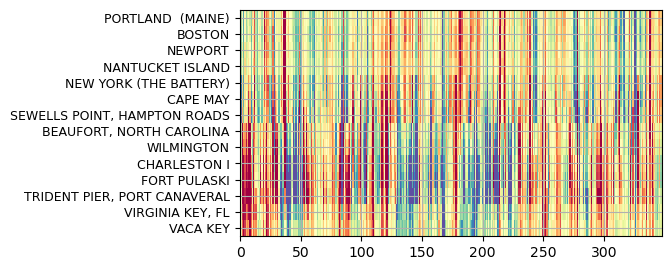

In [52]:
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin

for nsim in [0]:#np.arange(3):
    if nsim<1:
        plotvar=hr_tg.T
    else:
        if nsim<2:
            plotvar=hr_tg.T
        else:
            plotvar=lr_tg.T

    ax1 = plt.subplot2grid((3,5), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        np.arange(len(hr_tg.time)),
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )

    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = tgnames[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)
plt.savefig('s3.png',
)

/glade/derecho/scratch/clittle/tmp/ipykernel_45059/2273334117.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


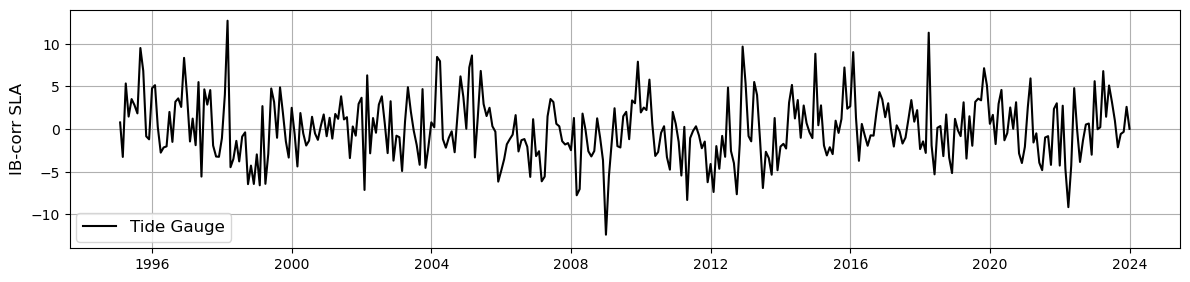

In [53]:
fig = plt.figure(figsize=(12,8), tight_layout=True)

ax = plt.subplot2grid((3,3), (2,0), colspan=3, rowspan=1)    
# for nsim in np.arange(1):
    
line = ax.plot(hr_tg.time,hr_tg.mean(dim='tgindex'),'k', label = 'data')

plt.ylim(-14,14)
plt.grid()
plt.ylabel('IB-corr SLA',fontsize=12)
ax.legend([],     # The line objects
       labels=["Tide Gauge", "HR", "LR"],   # The labels for each line
       loc="lower left",   # Position of legend
       borderaxespad=0.4,    # Small spacing around legend box
       title="",
       fontsize=12,# Title for the legend
       )

## tide gauge EOFs

In [61]:
import xeofs
kwargs = dict(n_modes=len(hr_tg.tgindex)-1,random_state=2)#, normalize=True)
expvars=[]
pcs=[]
amps=[]
phases=[]
recs_m1=[]
recs_m2=[]
recs_m3=[]
recs_tot=[]
real_ts=[]
djf_flag=True
djf_flag=False

for nsim in np.arange(1):
    if nsim<1:
        dain=hr_tg.T
    else:
        if nsim<2:
            dain=hr_tg.T+xr_tg.TG_IB_CORR*0
        else:
            dain=lr_tg.T+xr_tg.TG_IB_CORR*0
    
    # model = xeofs.models.ComplexEOF(padding="none", **kwargs)
    # model = xeofs.models.EOF(**kwargs)
    model = xeofs.single.EOF(**kwargs)
    model.fit(dain, dim=("time"))
    expvar = model.explained_variance()
    expvar_ratio = model.explained_variance_ratio()
    amp = model.components()
    phase = amp
    # amp = model.components_amplitude()
    # phase = model.components_phase()
    phase = phase-phase.sel(tgindex='351')
    scores = model.scores(normalized=True)
    
    expvars.append(expvar_ratio)
    real_ts.append(dain)
    pcs.append(scores)
    amps.append(amp)
    phases.append(phase)
    
    rec=model.inverse_transform(scores[0,:],normalized=True)
    recs_m1.append(rec)
    rec=model.inverse_transform(scores[1,:],normalized=True)
    recs_m2.append(rec)
    rec=model.inverse_transform(scores[2,:],normalized=True)
    recs_m3.append(rec)
    rec=model.inverse_transform(scores,normalized=True)
    recs_tot.append(rec)
    if nsim<1:
        tgout=dain

In [62]:
for nsim in np.arange(len(pcs)): 
    # total_var=real_ts[nsim].var(dim='time')
    norm_fac=np.real(pcs[nsim]).std(dim='time')
    pcs[nsim]=np.real(pcs[nsim])/norm_fac
    amps[nsim]=np.real(amps[nsim])/norm_fac

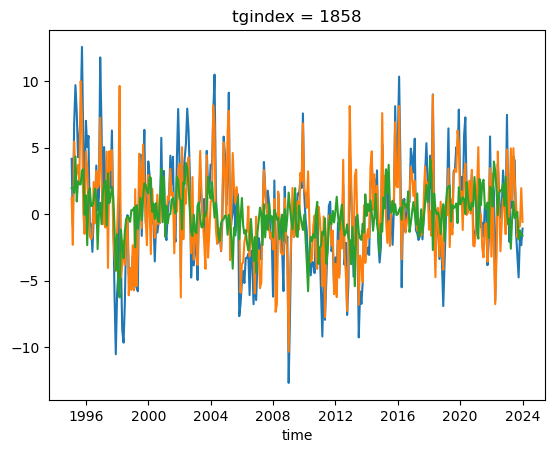

In [63]:
ntg=1
nsim=0
real_ts[nsim][:,ntg].plot()
recs_m1[nsim][:,ntg].plot()
recs_m2[nsim][:,ntg].plot()

In [64]:
expvars[0].values

array([6.89488160e-01, 2.54563600e-01, 2.69790357e-02, 1.39694894e-02,
       6.24791955e-03, 3.75855284e-03, 1.75640702e-03, 1.03640189e-03,
       8.93570109e-04, 5.15094670e-04, 2.93131408e-04, 2.73886037e-04,
       1.41214644e-04])

In [65]:
rotated_crs = ccrs.RotatedPole(pole_longitude=25.0, pole_latitude=70.0) # define projection!
varscale=300
vmaxin=7
cols=['k','C1','C0','C2','C3','C4','C5','C6']   

In [72]:
def plot_obs_pcs(tgpcs,vmaxin, varscale):
    fig = plt.figure(figsize=(10,13))#, tight_layout=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    nsim=0
    tot_var=recs_tot[nsim].var(dim='time')    

    ylabspacing = 2
    
    vmin = -12
    vmax2 = -vmin

    for nmode in np.arange(3):
        ax = plt.subplot2grid((5,3), (2, nmode), colspan=1, rowspan=2, projection=rotated_crs)#, aspect="auto")
        pos = ax.get_position() # get the original position 
        vmin=-vmaxin
        vmax=-vmin

        if nmode<1:    
            VE=recs_m1[nsim].var(dim='time')/tot_var
        else:
            if nmode<2:    
                VE=recs_m2[nsim].var(dim='time')/tot_var
            else:
                VE=recs_m3[nsim].var(dim='time')/tot_var
        
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=amps[nsim][nmode,:],
            cmap=cmap,  # this is the changes
            # s=varscale*VE**2,
            s=varscale/2,
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=ccrs.PlateCarree(),
        )  ## Important
        
        # for nkey in np.arange(2):
        #     varval=varscale*(.25+.5*nkey)**2
            
        #     varkey = plt.scatter(
        #         x=tgs_in.lon,
        #         y=tgs_in.lat,
        #         vmin=vmin,
        #         vmax=vmax,
        #         c=amps[nsim][nmode,:],
        #         cmap=cmap,  # this is the changes
        #         s=varval,
        #         alpha=1,
        #         edgecolors=".6",
        #         linewidth=1,
        #         # marker=None,
        #         zorder=7,
        #         transform=ccrs.PlateCarree(),
        #     )  ## Important
            
        #     varkey.set_facecolor("none")   

        ax.set_extent([-74, -78, 20, 48], crs=ccrs.PlateCarree())        
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nmode<1:
            cbar_ax = fig.add_axes(
                [pos.x1-(pos.x1 - pos.x0)/4, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF (cm/SD)", rotation=0, size=10, weight="bold")
            cbar.ax.tick_params(labelsize=10)
                
        # ax.text(.02,.95, 'PC' + str(nsp+1) + ' lags by ' + str(lagx) + ' months' , transform=ax.transAxes, fontsize=12, weight='bold')
        # plt.figtext(-110,-40, "LF VE. = {:.0}".format(VE[nsp]), horizontalalignment='right', verticalalignment='center', fontsize=16, transform=ax.transAxes)
        # plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + 'EOF'+str(nmode+1), horizontalalignment='left', 
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvars[nsim][nmode].values*100)+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
    import matplotlib.dates as mdates
    ax = plt.subplot2grid((5,3), (4,0), colspan=3, rowspan=1)    
    for nsp in np.arange(2):
        line = ax.plot(pcs[nsim].time,pcs[nsim][nsp,:],cols[nsp], label = 'data')
    # years = mdates.YearLocator()   # every year
    # years_fmt = mdates.DateFormatter('%Y')
    # ax.xaxis.set_major_locator(years)
    # ax.xaxis.set_major_formatter(years_fmt)
    plt.grid()
    plt.ylabel('Normalized PC')
    ax.legend([],     # The line objects
           labels=["Model PC1","Model PC2"],   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
             )

/glade/derecho/scratch/clittle/tmp/ipykernel_45059/4246364641.py:96: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


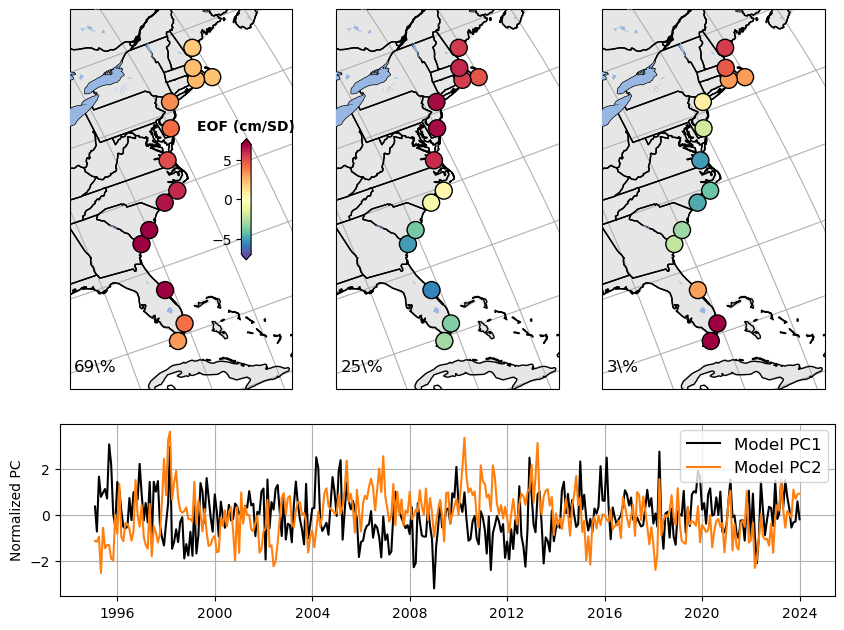

In [73]:
plot_obs_pcs(pcs[0],7, 300)#amps[nsim][0:2,:].max())
plt.savefig('s4.png',
)